# Introduction

_5/7/2023_

**Prepared by:** Danial Azmi

---

**Problem Statement**

The goal of the predictive model is to predict household income (HHI) based on the given dataset. Once the model is trained, it can be used to make predictions on new data by feeding in the relevant features and generating an output prediction for the HHI.

The overall goal of this machine learning model is to provide a tool for predicting HHI, which can have a wide range of applications in various fields such as economics, social science, public policy, and marketing research.

> I'll try to include some explanations on what my thought process was when doing this whole project. I had quite a tight time constraint to finish this due to a recent holiday where I decided to rest from any kind of work. I wish I had more time to answer all the questions I had for the project but maybe they'll be answered in a later effort on the project.

> In the middle parts I'll include all the questions that came to my mind, and all the assumptions that I made. I'll summarize everything at the end of the notebook to have a retrospective view on the analysis done.

# Preliminaries

Here I just do all the imports and ensure the data is loaded properly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from seaborn import heatmap

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
pd.options.display.float_format = '{:20,.4f}'.format

In [3]:
df = pd.read_csv(r'data/training-data.csv')
print(df.shape)

df = df[df['Type']=='HHI'].reset_index(drop=True)
print(df.shape)

(90571, 36)
(2361, 36)


In [4]:
df.head(5)

,AudienceID,LotameID,y,Name,Type,fullVisitorId,browser,operatingSystem,operatingSystemVersion,isMobile,...,onPageTime,nextTime,user_active_days,total_visit_counts,total_unique_session,total_time_spent,time_spent_per_session,timeOnPage,GAClientId,cookie_id
0,818744,cbb561a1af5a40eb684d55a8c0b2047a,1500-,"RMG - 1PD - Declared - HHI - <RM1,500\t",HHI,"10,531,342,589,549,778,944.0000",Chrome,Android,8.1.0,True,...,0,91472,5,43,5,735.0000,154.0000,91472,amp-35vZcqfyySaxus6_748cgw,IhHSD5tP1NnqeA1g
1,818744,cbb561a1af5a40eb684d55a8c0b2047a,1500-,"RMG - 1PD - Declared - HHI - <RM1,500\t",HHI,"10,531,342,589,549,778,944.0000",Chrome,Android,8.1.0,True,...,91472,103015,5,43,5,735.0000,154.0000,11543,amp-35vZcqfyySaxus6_748cgw,IhHSD5tP1NnqeA1g
2,818744,cbb561a1af5a40eb684d55a8c0b2047a,1500-,"RMG - 1PD - Declared - HHI - <RM1,500\t",HHI,"10,531,342,589,549,778,944.0000",Chrome,Android,8.1.0,True,...,103015,143773,5,43,5,735.0000,154.0000,40758,amp-35vZcqfyySaxus6_748cgw,IhHSD5tP1NnqeA1g
3,809023,e74bb87a1abb30abf105f2900a65e842,1.500-5000,RMG - 1PD - Declared - HHI - RM1.5K - RM5K\t,HHI,"1,158,781,765,718,776,832.0000",Chrome,Windows,7,False,...,0,126729,5,237,8,"1,385.0000",217.0000,126729,269799904.1574837317,7Zr54t-YOVCMSUWw
4,809023,e74bb87a1abb30abf105f2900a65e842,1.500-5000,RMG - 1PD - Declared - HHI - RM1.5K - RM5K\t,HHI,"1,158,781,765,718,776,832.0000",Chrome,Windows,7,False,...,126729,207157,5,237,8,"1,385.0000",217.0000,80428,269799904.1574837317,7Zr54t-YOVCMSUWw


## Helper Functions

In [5]:
## Plots a histogram, boxplot and provides a quantitative description of the data.

def summary(series):
    
    fig, axes = plt.subplots(1,2, figsize=(11,5))
    
    series.plot(kind='box', ax=axes[0])
    series.plot(kind='hist', bins=20, ax=axes[1])
    
    display(series.describe())
    
    return

In [6]:
## Counts the number of NA values

def checkna(df):
    return df.isna().sum()[df.isna().sum()>0]

# Preprocessing

## Missing value treatment

Seems like the only columns with missing values are just string columns. No numerics. <br><br>
This actually raises a question : <br> 
- _How reliable are the numeric columns?_

Perhaps later on we can try to answering this question when we explore the data further.

<br><br><br>
> For the missing pageTitle, I manually copied the title by visiting the url since it's just 1 missing value.

In [7]:
checkna(df)

mobileDeviceBranding          136
mobileDeviceModel             136
mobileInputSelector           136
mobileDeviceMarketingName     136
sub_sec                      1036
pageTitle                       1
dtype: int64

In [8]:
df[df['pageTitle'].isna()][['sec', 'sub_sec', 'url']]

,sec,sub_sec,url
81,/pernah-samakan-kemaluan-bekas-isteri-dengan-b...,NaN,https://ohbulan.com/pernah-samakan-kemaluan-be...


In [9]:
# I manually copied the title by visiting the url since it's just 1 missing value

df.loc[81, 'pageTitle'] = 'Pernah Samakan Kemaluan Bekas Isteri Dengan Bau Ikan Masin, Pelakon Akui Menyesal & Rindukan Anak'

<br><br><br>
> Next I take a glimpse at the _mobile_ columns and figured out they were null because the visitor accessed the site using a PC

In [10]:
checkna(df)

mobileDeviceBranding          136
mobileDeviceModel             136
mobileInputSelector           136
mobileDeviceMarketingName     136
sub_sec                      1036
dtype: int64

In [11]:
# To check if the columns with 136 nulls are all the same rows

df[
    (df['mobileDeviceBranding'].isna()) & 
    (df['mobileDeviceModel'].isna()) & 
    (df['mobileInputSelector'].isna()) &
    (df['mobileDeviceMarketingName'].isna())
].shape

(136, 36)

In [12]:
df[df['mobileDeviceBranding'].isna()].head(5)

,AudienceID,LotameID,y,Name,Type,fullVisitorId,browser,operatingSystem,operatingSystemVersion,isMobile,...,onPageTime,nextTime,user_active_days,total_visit_counts,total_unique_session,total_time_spent,time_spent_per_session,timeOnPage,GAClientId,cookie_id
3,809023,e74bb87a1abb30abf105f2900a65e842,1.500-5000,RMG - 1PD - Declared - HHI - RM1.5K - RM5K\t,HHI,"1,158,781,765,718,776,832.0000",Chrome,Windows,7,False,...,0,126729,5,237,8,"1,385.0000",217.0000,126729,269799904.1574837317,7Zr54t-YOVCMSUWw
4,809023,e74bb87a1abb30abf105f2900a65e842,1.500-5000,RMG - 1PD - Declared - HHI - RM1.5K - RM5K\t,HHI,"1,158,781,765,718,776,832.0000",Chrome,Windows,7,False,...,126729,207157,5,237,8,"1,385.0000",217.0000,80428,269799904.1574837317,7Zr54t-YOVCMSUWw
5,809023,e74bb87a1abb30abf105f2900a65e842,1.500-5000,RMG - 1PD - Declared - HHI - RM1.5K - RM5K\t,HHI,"1,158,781,765,718,776,832.0000",Chrome,Windows,7,False,...,44441,142871,5,237,8,"1,385.0000",203.0000,98430,269799904.1574837317,7Zr54t-YOVCMSUWw
13,809023,81f5fed7165c2ab7995465dbf6d5ee61,1.500-5000,RMG - 1PD - Declared - HHI - RM1.5K - RM5K\t,HHI,"1,483,772,560,735,865,856.0000",Chrome,Windows,10,False,...,0,364717,2,30,2,730.0000,365.0000,364717,345467720.1512180611,5LgVxDgzLA5I6DDi
14,809023,81f5fed7165c2ab7995465dbf6d5ee61,1.500-5000,RMG - 1PD - Declared - HHI - RM1.5K - RM5K\t,HHI,"1,483,772,560,735,865,856.0000",Chrome,Windows,10,False,...,81,132531,7,634,7,"101,631.0000",632.0000,132450,345467720.1512180611,5LgVxDgzLA5I6DDi


In [13]:
df[df['mobileDeviceBranding'].isna()]['operatingSystem'].value_counts()

Windows    136
Name: operatingSystem, dtype: int64

In [14]:
df['mobileDeviceBranding'].fillna('Windows', inplace=True)
df['mobileDeviceModel'].fillna('Windows', inplace=True)
df['mobileInputSelector'].fillna('cursor', inplace=True)
df['mobileDeviceMarketingName'].fillna('Windows', inplace=True)

df['mobileDeviceInfo'].replace('(not set)', 'Windows', inplace=True)

checkna(df)

sub_sec    1036
dtype: int64

<br><br><br>
> Next I take a look at the last column, and finally just decided to fill it with an empty string '' for now. <br>
Also decided to clean the text a little to remove all the slashes for _sub_ and _sub_sec_

In [15]:
checkna(df)

sub_sec    1036
dtype: int64

In [16]:
df[df['sub_sec'].notna()]['sub_sec'].value_counts()

/nation/                      475
/politics/                    200
/world/                       196
/crime-courts/                151
/groove/                       75
/2022/                         45
/badminton/                    36
/leaders/                      24
/football/                     15
/letters/                      14
/seismik/                      13
/sunday-vibes/                 11
/region/                       11
/government-public-policy/     10
/heal/                          9
/news/                          7
/columnists/                    7
/others/                        4
/makan/                         4
/fun/                           4
/jom/                           4
/nation                         3
/                               2
/tennis/                        2
/bots/                          1
/badminton                      1
/amp                            1
Name: sub_sec, dtype: int64

In [17]:
df['sub_sec'].fillna('/', inplace=True)

df['sub_sec'] = df['sub_sec'].str.replace('/', '')

df[df['sub_sec'].notna()]['sub_sec'].value_counts().head(5)

                1038
nation           478
politics         200
world            196
crime-courts     151
Name: sub_sec, dtype: int64

In [18]:
df['sec'].fillna('/', inplace=True)

df['sec'] = df['sec'].str.replace('/', '')

df[df['sec'].notna()]['sec'].value_counts().head(5)

             870
news         844
world        219
lifestyle    116
sports        61
Name: sec, dtype: int64

In [19]:
checkna(df)

Series([], dtype: int64)

In [20]:
df.shape

(2361, 36)

## EDA & Feature Engineering

Now that's done, we move on to the most time-consuming part of preprocessing, which is EDA.

Even for EDA I didn't have much time to spend, and couldn't really answer all of the questions I had. However there were still some interesting stuff that I managed to find.


### String features

> Taking a look at all the columns, it seems like there's more string columns than numeric columns. <br>
This means there's going to be quite alot of encoding work to do later on.

>One thing that piqued my interest is that why are there so many _ID_ columns?<br>
Usually IDs aren't used as a feature but before dropping them I wanted to take a look first.<br><br>
It seems like _LotameID_, _fullVisitorId_, _GAClientID_ aren't unique for every row, and they are always paired together (when 1 changes, the others also change).<br>
And just from eyeballing the data, it seems like the IDs represent 1 unique device/browser. So a single ID can be present in multiple rows, meaning they are returning users.
From here I'll just assume and generalize that:<br>
> * _A unique ID represents a person_
> * _A row represents a single site visit_

> Then this raises another question. Since we are trying to predict the HHI which is at person-level,
> * _Would it be more accurate to aggregate the data so that 1 row represents 1 person?_

> It seems like there's only 42 unique IDs. If I decide to aggregate the data to 1 row = 1 person, it would significantly decrease the number of observations. <br>
It might still be possible especially with regression, but for now I'll consider that as a future work.

In [21]:
df.dtypes

AudienceID                     int64
LotameID                      object
y                             object
Name                          object
Type                          object
fullVisitorId                float64
browser                       object
operatingSystem               object
operatingSystemVersion        object
isMobile                        bool
mobileDeviceBranding          object
mobileDeviceModel             object
mobileInputSelector           object
mobileDeviceInfo              object
mobileDeviceMarketingName     object
screenResolution              object
language                      object
continent                     object
subContinent                  object
country                       object
region                        object
city                          object
sec                           object
sub_sec                       object
pageTitle                     object
url                           object
onPageTime                     int64
n

In [22]:
print(df['AudienceID'].nunique())
print(df['LotameID'].nunique())
print(df['fullVisitorId'].nunique())
print(df['GAClientId'].nunique())
print(df['cookie_id'].nunique())

3
42
42
42
49


In [23]:
df.groupby(['fullVisitorId', 'LotameID', 'GAClientId']).count().shape

(42, 33)

In [24]:
df.groupby(['fullVisitorId', 'LotameID', 'GAClientId']).count().sort_values('y', ascending=False).head(5)

,,,AudienceID,y,Name,Type,browser,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,...,url,onPageTime,nextTime,user_active_days,total_visit_counts,total_unique_session,total_time_spent,time_spent_per_session,timeOnPage,cookie_id
fullVisitorId,LotameID,GAClientId,,,,,,,,,,,,,,,,,,,,,
"8,547,876,345,369,880,576.0000",196c30f4cdae19dd70c4d634a38b6b37,1990207551.1572628814,1320,1320,1320,1320,1320,1320,1320,1320,1320,1320,...,1320,1320,1320,1320,1320,1320,1320,1320,1320,1320
"5,197,989,544,560,529,408.0000",846349b894fb8ab473d5940ec70cae0,1210251251.1572441982,519,519,519,519,519,519,519,519,519,519,...,519,519,519,519,519,519,519,519,519,519
"513,091,887,291,771,392.0000",bf8e8d0a3026f468d80969ab351af4ce,119463514.1596533239,144,144,144,144,144,144,144,144,144,144,...,144,144,144,144,144,144,144,144,144,144
"1,483,772,560,735,865,856.0000",81f5fed7165c2ab7995465dbf6d5ee61,345467720.1512180611,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
"6,287,112,969,319,102,464.0000",37d0d3bf3d3c48261908dddd9cbf02cc,1463832559.1594111754,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39


In [25]:
df.groupby(['fullVisitorId', 'LotameID', 'GAClientId']).nunique()['y'].sum()

42

<br><br><br>
> Here I decide to take a look at the _mobile_ columns, because there's so many of them. <br>
Just from eyeballing I see that the _mobileDeviceInfo_ and _mobileDeviceMarketingName_ seems quite redundant to _mobileDeviceBranding_ and _mobileDeviceModel_, and decide to just drop them.

In [26]:
mobile_cols = df.columns[df.columns.str.find('mobile')>=0]

df[mobile_cols]

,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName
0,Xiaomi,Redmi 6A,touchscreen,Xiaomi Redmi 6A,(not set)
1,Xiaomi,Redmi 6A,touchscreen,Xiaomi Redmi 6A,(not set)
2,Xiaomi,Redmi 6A,touchscreen,Xiaomi Redmi 6A,(not set)
3,Windows,Windows,cursor,Windows,Windows
4,Windows,Windows,cursor,Windows,Windows
...,...,...,...,...,...
2356,Huawei,EML-L29,touchscreen,Huawei EML-L29 P20,P20
2357,Huawei,EML-L29,touchscreen,Huawei EML-L29 P20,P20
2358,Huawei,EML-L29,touchscreen,Huawei EML-L29 P20,P20
2359,Huawei,EML-L29,touchscreen,Huawei EML-L29 P20,P20


In [27]:
to_drop = [
    'fullVisitorId',
    'AudienceID',
    'GAClientId',
    'cookie_id',
    'Name',
    'Type',
    'mobileDeviceInfo',
    'mobileDeviceMarketingName'
]

df.drop(to_drop, axis=1, inplace=True)
df = df.drop_duplicates().reset_index(drop=True)

df.columns

Index(['LotameID', 'y', 'browser', 'operatingSystem', 'operatingSystemVersion',
       'isMobile', 'mobileDeviceBranding', 'mobileDeviceModel',
       'mobileInputSelector', 'screenResolution', 'language', 'continent',
       'subContinent', 'country', 'region', 'city', 'sec', 'sub_sec',
       'pageTitle', 'url', 'onPageTime', 'nextTime', 'user_active_days',
       'total_visit_counts', 'total_unique_session', 'total_time_spent',
       'time_spent_per_session', 'timeOnPage'],
      dtype='object')

<br><br><br>
> Now that we dropped some of the unneeded columns and deduped the rows, I wanna look back at _sec_ because I noticed that some of them didn't seem like 'sections', but were just page titles. <br>
It's going to be a problem if there's too many unique values if we decide to do one-hot encoding since it'll generate alot of features. <br><br>
We don't want the number of features to be have a high proportion to our number of observations. <br>


> After some checks, I decided generalize some of the values in _sec_ <br>
> * values like ```search?keywords...``` -> ```search```
> * values like ```business?page...``` -> ```business```
> * page titles like ```berbulu-telin...``` -> ```general```
> * empty values ``` ``` -> ```home```
>
> With this I managed to narrow down from 89 unique values to only 12.
>
> There might be more accurate ways to represent this, but I'm unable to come up with a better solution without a better understanding of the data. Hence:
> * _Is there a better way to group ```sec``` and ```sub_sec```?_



In [28]:
print('Unique values:', df['sec'].nunique())
pd.DataFrame(df['sec'].value_counts().head(20))

Unique values: 89


,sec
news,308
,285
world,83
lifestyle,46
sports,33
business,32
opinion,13
my,10
kantoi-masuk-bilik-tidur-anak-tiri-isteri-tetak-kemaluan-suami-lepas-tengok-rakaman-web-cam,8
wanita-dirogol-6-lelaki-di-hadapan-suami-2-orang-anak-ketika-dalam-perjalanan-pulang-dari-kebun,7


In [29]:
df[(df['sec'].str.find('search?')>=0) | (df['sec'].str.find('business?')>=0)]['sec']

146                             business?page=1
147                             business?page=2
148                             business?page=3
151                             business?page=4
153                             business?page=5
156                             business?page=6
158                       search?keywords=etoro
159                search?keywords=etoro&page=1
160                       search?keywords=etoro
161         search?keywords=gleneagles hospital
162                    search?keywords=hospital
163            search?keywords=hospital revenue
165     search?keywords=hospital revenue&page=1
167    search?keywords=hospital medical revenue
168              search?keywords=KPJ healthcare
563               search?keywords=seniman agung
564        search?keywords=seniman agung&page=1
Name: sec, dtype: object

In [30]:
df[(df['sec']=='')]['url'].value_counts()

https://www.nst.com.my/    281
https://ohbulan.com/         4
Name: url, dtype: int64

In [31]:
business_idx = df[df['sec'].str.find('business?')>=0].index
search_idx = df[df['sec'].str.find('search?')>=0].index
general_idx = df[(df['sec'].str.find('-')>=1)]['sec'].index
home_idx = df[(df['sec']=='')]['sec'].index

df.loc[business_idx, 'sec'] = 'business'
df.loc[search_idx, 'sec'] = 'search'
df.loc[general_idx, 'sec'] = 'general'
df.loc[home_idx, 'sec'] = 'home'

In [32]:
print('Unique values:', df['sec'].nunique())
pd.DataFrame(df['sec'].value_counts())

Unique values: 12


,sec
news,308
home,285
general,107
world,83
lifestyle,46
business,38
sports,33
opinion,13
search,11
my,10


<br><br><br>
> Another thing I felt might be interesting was to see what sites were actually visited. Just a quick hypothesis that popped on my head was:
> * _Different websites would have different distribution of HHI groups_

> After doing a quick check, unfortunately in this dataset there weren't many websites included. Only 3, with NST making up the majority of it. <br>
Nonetheless, it might be interesting to see create a new feature from this and see if it actually impacts the result.

In [33]:
df['url'].head(20)

0     https://ohbulan.com/video-nak-marah-tapi-kena-...
1     https://ohbulan.com/suami-jual-isteri-peroleh-...
2     https://ohbulan.com/suami-jual-isteri-peroleh-...
3     https://ohbulan.com/rakyat-malaysia-maut-dibun...
4     https://ohbulan.com/datuk-74-tahun-maut-selepa...
5     https://ohbulan.com/berlaku-pendarahan-tisu-ko...
6     https://www.nst.com.my/news/nation/2022/04/787...
7     https://www.nst.com.my/news/nation/2022/03/782...
8     https://ohbulan.com/video-bekas-juara-hero-rem...
9     https://ohbulan.com/video-aedy-ashraf-buat-kej...
10    https://ohbulan.com/wanita-dirogol-6-lelaki-di...
11    https://ohbulan.com/wanita-dirogol-6-lelaki-di...
12                                 https://ohbulan.com/
13    https://says.com/my/news/sg-rolls-royce-holds-...
14                              https://www.nst.com.my/
15    https://www.nst.com.my/sports/badminton/2022/0...
16                         https://www.nst.com.my/world
17    https://www.nst.com.my/world/region/2022/0

In [34]:
df['base_url'] = df['url'].str.extract(r'(^http.*?(com\/|my\/))')[0]

In [35]:
df['base_url'].value_counts()

https://www.nst.com.my/    815
https://ohbulan.com/       113
https://says.com/           10
Name: base_url, dtype: int64

<br><br><br>
> I noticed that some values in _pageTitle_ had a [VIDEO] substring at the start. Out of curiosity, it might be interesting to see if labelling these sites would have an impact on the model.

In [36]:
df['pageTitle']

0      [VIDEO] Nak Marah Tapi Kena Sabar, Anak Diam R...
1      Suami Jual Isteri, Peroleh Hampir RM3k Sebulan...
2      Suami Jual Isteri, Peroleh Hampir RM3k Sebulan...
3      Rakyat Malaysia Maut 'Dibunuh' Di Australia, D...
4      Datuk 74 Tahun Maut Selepas Tunai 'Hajat' Di R...
                             ...                        
933      'Let market forces decide Sapura Energy's fate'
934    Malaysia 'happier' than China but not as 'happ...
935    Surging semiconductor ASPs, higher oil prices ...
936    Surging semiconductor ASPs, higher oil prices ...
937    Surging semiconductor ASPs, higher oil prices ...
Name: pageTitle, Length: 938, dtype: object

In [37]:
df['containsVideo'] = df['pageTitle'].str.find('VIDEO')>=0
df['containsVideo'].value_counts()

False    922
True      16
Name: containsVideo, dtype: int64

<br><br><br>
### Numerical features
> That'll do for the string columns. For the numeric features, some questions I thought of before starting anything was:
> * _What are the definitions?_
> * _How reliable are the features?_ (from previous)
> * _Are there any features we can derive that can improve the model?_
> * _Are there any high correlation features we can drop?_

> I tried my best to answer these questions but unfortunately I felt like I was spending more time than I anticipated in this process. <br>
I was also starting to go down further into different rabbit holes that didn't really provide much impact as I hoped. <br>
Hence I couldn't really do a very thorough analysis on this part due to time constraints even though it's the most exciting section. <br><br>
I also **decided to not include the codes that I did for this** as it was half-finished and would just seem confusing. I shall just summarize the insights I gained.

> Some findings:
> * When trying to understand the definition of _onPageTime_ & _timeOnPage_ and trying to verify their integrity, I simply found that ```timeOnPage = nextTime - onPageTime```.
> * _onPageTime_ and _nextTime_ seems like some kind of timestamp, but I couldn't really make out the format (is it seconds relative to the time the site was opened?)
> * I would assume that ```time_spent_per_session = total_time_spent / total_unique_session``` but it didn't tally with manually made the calculations.
> * Some of the features had absurdly high max values that didn't make sense, hence later on we'll need to remove outliers.

In [38]:
df.describe()

,onPageTime,nextTime,user_active_days,total_visit_counts,total_unique_session,total_time_spent,time_spent_per_session,timeOnPage
count,938.0000,938.0000,938.0000,938.0000,938.0000,938.0000,938.0000,938.0000
mean,"248,211.5235","393,353.9104",20.3124,"1,940.0778",51.7303,"122,135.4009",645.6652,"145,142.3870"
std,"401,806.5821","480,063.1835",8.2993,"1,198.0066",28.6755,"94,941.0719",596.1814,"269,142.5100"
min,0.0000,"4,553.0000",1.0000,1.0000,1.0000,54.0000,8.0000,213.0000
25%,"1,037.2500","89,398.0000",14.0000,760.0000,19.0000,"24,783.0000",213.2500,"23,987.0000"
50%,"81,599.0000","221,514.5000",24.0000,"2,041.0000",71.0000,"97,538.0000",482.0000,"63,395.5000"
75%,"303,544.2500","500,900.7500",25.0000,"3,328.0000",73.0000,"243,007.0000",822.0000,"132,645.0000"
max,"2,448,447.0000","3,805,761.0000",30.0000,"3,328.0000",79.0000,"243,007.0000","3,806.0000","2,357,471.0000"


C:\Users\DataMicron\AppData\Local\Temp\ipykernel_20528\2523787037.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap(df.corr(), annot=True)


<Axes: >

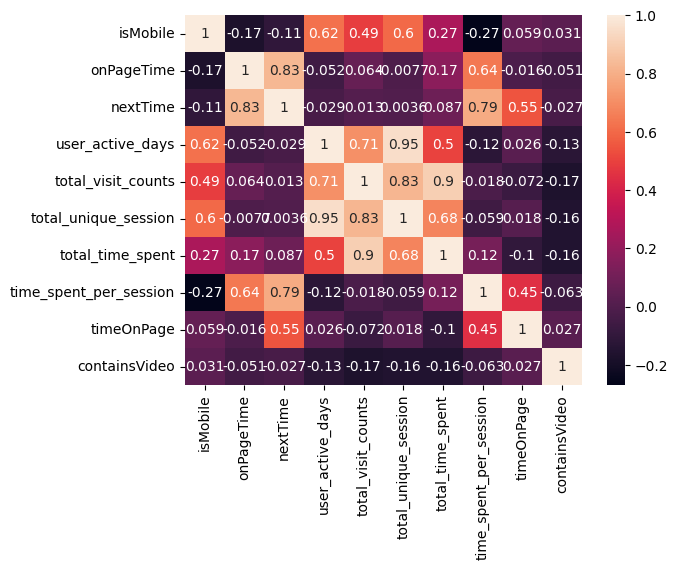

In [39]:
heatmap(df.corr(), annot=True)

## Removing Outliers

> The features that had very high max values (relative to the mean and quantiles) were mainly features that were related to 'time'. <br><br>
To be more specific, it's these features:
> * time_spent_per_session
> * onPageTime
> * nextTime
> * timeOnPage

> Since _timeOnPage_ is derived, removing the outliers for this feature alone should also resolve outlier issues with _onPageTime_ and _nextTime_ <br><br>
So I decided to remove outliers for _time_spent_per_session_ and _timeOnPage_ using the basic **1.5*IQR rule**.

> A total of 129 rows were excluded (13.75%) of the dataset, which is actually quite alot of data loss in my personal opinion. <br>
However I felt like the outliers were very extreme and would negatively affect the model hence I still decided to remove them.

count               938.0000
mean            145,142.3870
std             269,142.5100
min                 213.0000
25%              23,987.0000
50%              63,395.5000
75%             132,645.0000
max           2,357,471.0000
Name: timeOnPage, dtype: float64

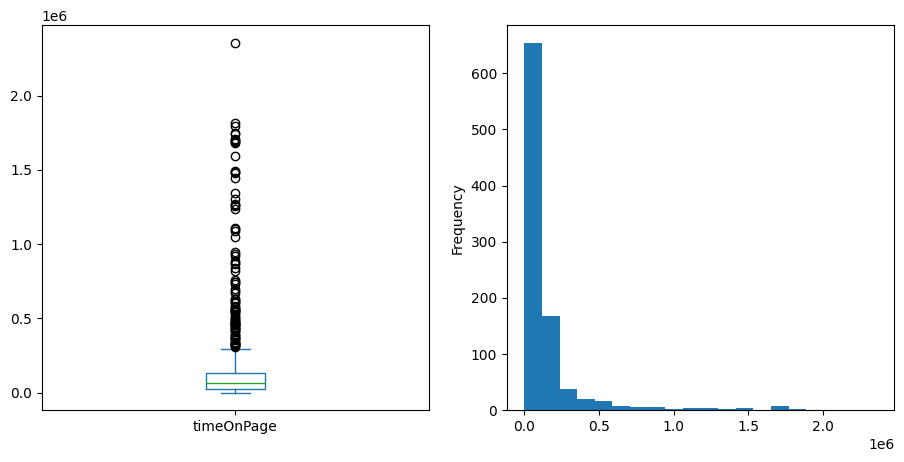

In [40]:
summary(df['timeOnPage'])

count               938.0000
mean                645.6652
std                 596.1814
min                   8.0000
25%                 213.2500
50%                 482.0000
75%                 822.0000
max               3,806.0000
Name: time_spent_per_session, dtype: float64

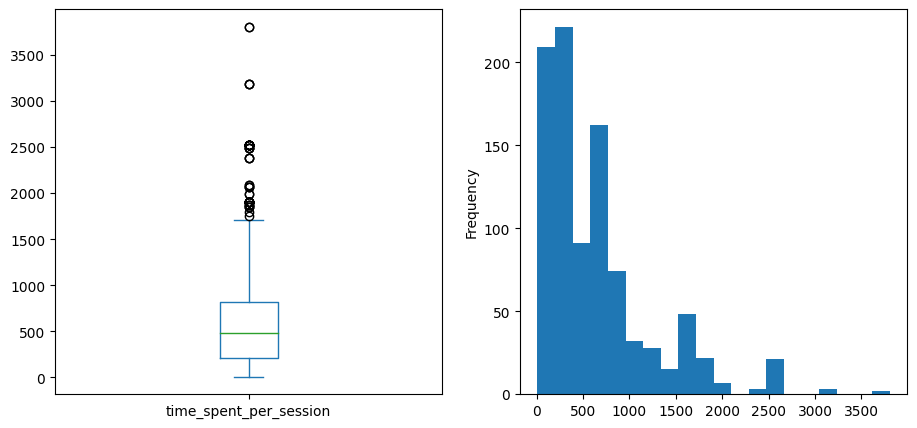

In [41]:
summary(df['time_spent_per_session'])

In [42]:
fence_timeOnPage = df['timeOnPage'].quantile(0.75)+(1.5*df['timeOnPage'].quantile(0.75)-df['timeOnPage'].quantile(0.25))
fence_time_spent_per_session = df['time_spent_per_session'].quantile(0.75)+(1.5*df['time_spent_per_session'].quantile(0.75)-df['time_spent_per_session'].quantile(0.25))

n_rows = df[(df['timeOnPage']>=fence_timeOnPage) | (df['time_spent_per_session']>=fence_time_spent_per_session)].shape[0]

print('Rows that will be removed:')
print(str(n_rows) + ' rows - {0:.2f}%'.format((n_rows/df.shape[0])*100))

Rows that will be removed:
129 rows - 13.75%


In [43]:
df.shape

(938, 30)

In [44]:
df = df[(df['timeOnPage']<fence_timeOnPage) & (df['time_spent_per_session']<fence_time_spent_per_session)]

In [45]:
df.shape

(809, 30)

count               809.0000
mean             73,624.4747
std              64,214.1502
min                 213.0000
25%              21,461.0000
50%              54,783.0000
75%             107,788.0000
max             289,905.0000
Name: timeOnPage, dtype: float64

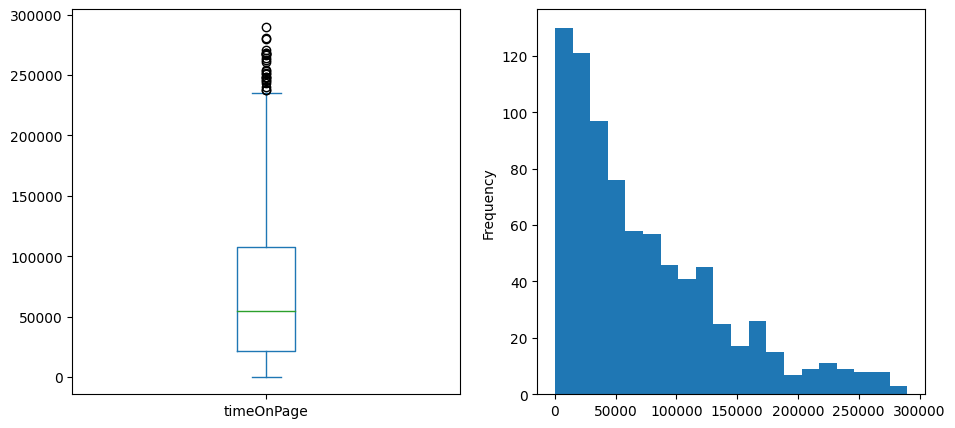

In [46]:
summary(df['timeOnPage'])

count               809.0000
mean                503.8764
std                 403.9330
min                   8.0000
25%                 193.0000
50%                 369.0000
75%                 741.0000
max               1,710.0000
Name: time_spent_per_session, dtype: float64

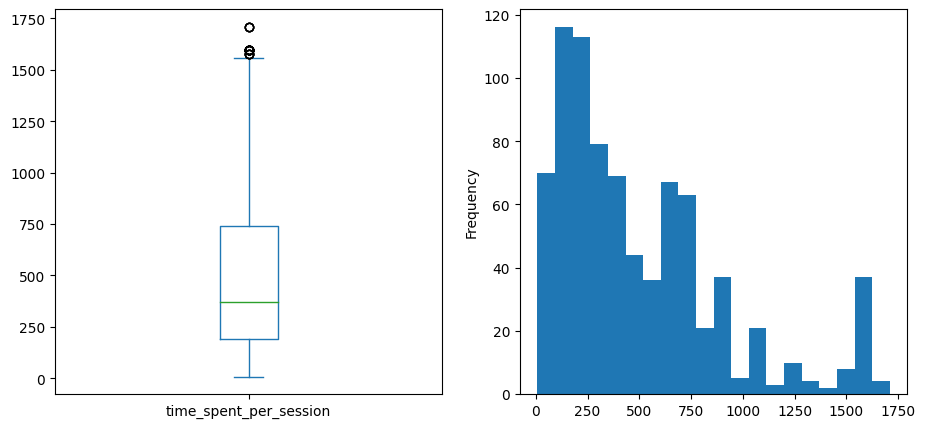

In [47]:
summary(df['time_spent_per_session'])

In [48]:
df.describe()

,onPageTime,nextTime,user_active_days,total_visit_counts,total_unique_session,total_time_spent,time_spent_per_session,timeOnPage
count,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000,809.0000
mean,"197,680.3362","271,304.8109",20.4351,"1,979.8653",52.0766,"124,566.5711",503.8764,"73,624.4747"
std,"279,123.0659","281,021.7062",8.3292,"1,214.3554",28.6137,"97,085.5251",403.9330,"64,214.1502"
min,0.0000,"4,553.0000",1.0000,1.0000,1.0000,54.0000,8.0000,213.0000
25%,"1,202.0000","74,156.0000",14.0000,760.0000,19.0000,"18,091.0000",193.0000,"21,461.0000"
50%,"75,866.0000","182,410.0000",24.0000,"2,041.0000",71.0000,"97,538.0000",369.0000,"54,783.0000"
75%,"280,809.0000","355,045.0000",24.0000,"3,328.0000",71.0000,"243,007.0000",741.0000,"107,788.0000"
max,"1,574,667.0000","1,710,116.0000",30.0000,"3,328.0000",79.0000,"243,007.0000","1,710.0000","289,905.0000"


## Categorical Encoding

> Now there's quite a lot of string features. Two approaches for encoding is basically label encoding and one-hot encoding. <br>
<br> There are advantages and disadvantages for these two, hence in this project I'll be performing both encoding approaches for different columns.

> Generally speaking, the approach I'll be taking is using one-hot encoding for nominal data and label encoding for ordinal data since that's ideal.

### Label encoding

> For this part I did it in two parts, just to identify some features that has <=2 unique values which can be basically represented in a boolean format. <br>
The second part is just performing label encoding to the rest of the ordinal data. <br><br>
Affected features:
> * operatingSystem
> * mobileInputSelector
> * continent
> * subContinent
> * y
> * operatingSystemVersion
> * screenResolution


In [49]:
df.dtypes[df.dtypes=='object']

LotameID                  object
y                         object
browser                   object
operatingSystem           object
operatingSystemVersion    object
mobileDeviceBranding      object
mobileDeviceModel         object
mobileInputSelector       object
screenResolution          object
language                  object
continent                 object
subContinent              object
country                   object
region                    object
city                      object
sec                       object
sub_sec                   object
pageTitle                 object
url                       object
base_url                  object
dtype: object

In [50]:
# Columns where there are <= 2 unique values, can turn into bool

df.dtypes[(df.nunique()<=2) & (df.dtypes=='object')]

operatingSystem        object
mobileInputSelector    object
continent              object
subContinent           object
dtype: object

In [51]:
cols = df.dtypes[(df.nunique()<=2)].index
cols

le = LabelEncoder()

for col in cols:
    
    df[col] = le.fit_transform(df[col])
    df[col] = df[col].astype('bool')

In [52]:
df.dtypes[df.dtypes=='object']

LotameID                  object
y                         object
browser                   object
operatingSystemVersion    object
mobileDeviceBranding      object
mobileDeviceModel         object
screenResolution          object
language                  object
country                   object
region                    object
city                      object
sec                       object
sub_sec                   object
pageTitle                 object
url                       object
base_url                  object
dtype: object

In [53]:
reso = df['screenResolution'].str.split('x', expand=True)
reso = reso[0].astype(int) * reso[1].astype(int)

df['screenResolution'] = reso
df['screenResolution']

0       259200
1       259200
2       259200
3      1440000
4      1440000
        ...   
929     409920
930     409920
935     212800
936     212800
937     212800
Name: screenResolution, Length: 809, dtype: int32

In [54]:
df.loc[:, df.dtypes[df.dtypes=='object'].index].nunique()

LotameID                   40
y                           3
browser                     3
operatingSystemVersion     10
mobileDeviceBranding       11
mobileDeviceModel          32
language                    6
country                     3
region                     11
city                       19
sec                        12
sub_sec                    24
pageTitle                 385
url                       407
base_url                    3
dtype: int64

In [55]:
# manually changing y values as natively using LabelEncoder will produce wrong order

df.loc[df[df['y']=='1500-'].index, 'y'] = 0
df.loc[df[df['y']=='1.500-5000'].index, 'y'] = 1
df.loc[df[df['y']=='5000+'].index, 'y'] = 2


df['y'] = df['y'].astype('int32')

In [56]:
# Label encoding

le_targets = [
    'operatingSystemVersion',
    'screenResolution'
]

for col in le_targets:
    
    df[col] = le.fit_transform(df[col])
    df[col] = df[col].astype('int32')

In [57]:
df.drop(['pageTitle', 'url'], axis=1, inplace=True)

<br><br><br>
> Now that label encoding is done, the only thing left is to perform one-hot encoding on the rest of the features. <br>
I also double checked the number of unique values for each feature, and the sum isn't too big.<br><br>
Probably won't need to worry about having too high proportion of ```number of features : number of observations```

In [58]:
df.loc[:, df.dtypes[df.dtypes=='object'].index].nunique()

LotameID                40
browser                  3
mobileDeviceBranding    11
mobileDeviceModel       32
language                 6
country                  3
region                  11
city                    19
sec                     12
sub_sec                 24
base_url                 3
dtype: int64

In [59]:
df.dtypes[df.dtypes=='object'].index[1:]

Index(['browser', 'mobileDeviceBranding', 'mobileDeviceModel', 'language',
       'country', 'region', 'city', 'sec', 'sub_sec', 'base_url'],
      dtype='object')

In [60]:
ohe_cols = df.dtypes[df.dtypes=='object'].index[1:]

for col in ohe_cols:
    
    df[col] = df[col].str.replace(' ', '_')
    
    df = pd.get_dummies(df, columns=[col], drop_first=True)

In [61]:
df.dtypes[df.dtypes=='object']

LotameID    object
dtype: object

# Summary

As a result of this whole process, some stuff that I learned about the data:

#### Assumptions

- A single row represents a single site visit
- A single unique LotameID represents a single person

<br><br>

#### Questions asked

Personally, I'm not able to answer most of these questions with very high confidence due to 2 generalized reasons 
1. Time constraints
2. I can only make inferences and assumptions without proper documnetation and definitions.

Nonetheless, the questions can perhaps be answered given enough time and curiosity to investigate the data.

<br><br>

- What are the definitions?
> There's no concrete way to identify them without proper documentations, one can only make assumptions.

<br>

- How reliable are the numeric features? 
> Not enough time to fully investigate, but with the current data provided, I would infer that not all the values are 100% reliable

<br>

- Would it be more accurate to aggregate the data so that 1 row represents 1 person?
> There are only 42 unique people, hence the data is probably too small. 

<br>

- Is there a better way to group sec and sub_sec?
> For now, doesn't seem like it but possible to do further experiments to check.

<br>

- Different websites would have different distribution of HHI groups
> Not enough variety of websites in dataset.

<br>

- Are there any features we can derive that can improve the model?
> Not enough time to investigate.

<br>

- Are there any high correlation features we can drop?
> Not enough time to experiment.

---

> Now all the features should be converted to numerical (asides from LotameID).<br>
Just another quick check to see the distribution of the y labels to see if they're evened out and save it to a csv.

<Axes: >

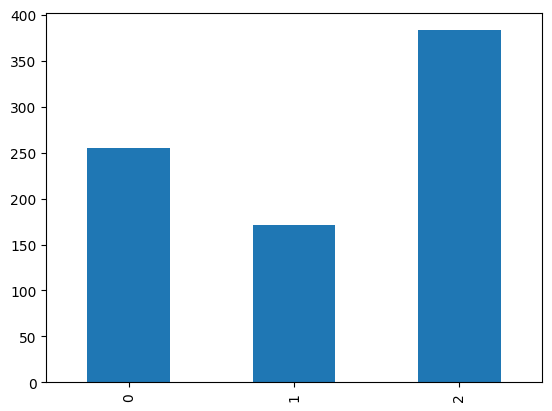

In [65]:
# Just to note,
#     0 = '-1500'
#     1 = '1.500-5000'
#     2 = '5000+'

df['y'].value_counts().sort_index().plot(kind='bar')

In [63]:
df.to_csv('training_prepped_v1.csv')

## Future work

- How about approaching the problem with classification instead of regression since the _y_ labels are basically a class interval?
- We can also apply oversampling/undersampling to make the labels equally distributed

